In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import scipy as sp
from os.path import join as pjoin
from scipy import signal
import seaborn as sns
import scipy as sp
import os
from matplotlib.backends.backend_pdf  import PdfPages
import spirometry
import gnar
import settings

In [6]:
settings = {
    "inputfolder": r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/Thesis/01-220/V2 gnarpy',
    #enter the name of the file and the breath number you wish to exclude from the IC volume drift correction
    "ignoreic": [
        ["01-220_V2_IC220.txt", [12]]
    ],
    #enter the name of the file and the breath number you wish to exclude from volume drift correction and averaging
    "ignorebreath":[
        ["01-220_V2_IC220.txt", [12]]
    ],
    "saveiccorrection": False, #saves a plot with the ic trend correction to check for incorrect EELV detection
    "saverawflowvolume": False, #saves a plot of the raw flow and volume traces
    "saveflowvolumeloops": False, #saves a plot with the FV loop and MEFV for each stage
    "saveoutput": True, #saves an excel of the dataframe containing data for each stage of exercise
    "savemefv": False, #saves a figure of the MEFV curve with all FVCs
    "savemefvdata": False, #saves an excel with fvc, fev1, pef, slope ratio, and data for the MEFV curve
    "saveaveragedata": False #saves an excel with the data of the average flow volume loop for each stage
}

In [ ]:
def correcttrend(volume, file):
        """corrects volume trend"""

        vol = volume.squeeze()
        peaks = signal.find_peaks((vol*-1), prominence=0.05, distance=0.25 * 1000)[0]
        f = sp.interpolate.interp1d(peaks, vol[peaks], 'linear', fill_value="extrapolate")
        peaksresampled = f(np.linspace(0, vol.size-1, vol.size))
        corvol = volume - peaksresampled
        
        return corvol


def correcttrendic(volume, input_path, pdf, settings):
    """
    corrects drift and trend for the IC breaths, does not include final expiration
    before the IC to account for participant changes in breathing 
    """
    vol = volume.squeeze()

    peaks = signal.find_peaks((vol), distance=500, prominence=0.25)[0]
    valleys = signal.find_peaks((vol*-1), distance=500, prominence=0.25)[0]
    peaks = peaks[:len(peaks)-1]
    # ib = ignorebreaths(input_path, True, settings)
    # if len(ib) > 0:
    #     peaks = np.delete(peaks, ib)

    z = np.polyfit(peaks, vol[peaks], 1)
    p = np.poly1d(z)

    peaksresampled = p(np.linspace(0, vol.size-1, vol.size))
    corvol = volume - peaksresampled
    
    if settings['saveiccorrection']:
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
        fig.suptitle("Trend correction and selection of IC volume for " + os.path.basename(input_path), fontsize=15)
        axes[0].plot(volume)
        axes[0].plot(peaks, vol[peaks], "x", markersize=20)
        axes[0].set_title("Uncorrected volume with end of expiration marked")
        axes[0].set_ylabel("Volume (L)")
        axes[1].plot(volume, linewidth=1.5)
        axes[1].plot(peaksresampled, linewidth=1.5)
        axes[1].set_title("Uncorrected volume with line of best fit for end expiratory volume")
        axes[1].set_ylabel("Volume (L)")
        axes[2].plot(corvol)
        axes[2].plot(np.zeros(corvol.size), '--', linewidth=1.5)
        axes[2].set_title("Corrected volyme with line of best fit set to 0")
        axes[2].set_ylabel("Volume (L)")

        for x in range(3):
            count=1
            yl = list(axes[x].get_ylim())
            for point in valleys:
                axes[x].axvline(x=point, color="grey", ls="--", lw=1)
                if count != len(valleys):
                    text = " #" + str(count)
                    # axes[x].text(point, yl[1]-((yl[1]-yl[0])*0.05), text, fontsize=8)   
                    axes[x].text(point, yl[0], text, fontsize=8)   
                    count+=1

        pdf.savefig()
        plt.close()
    
    return corvol

def get_ic(ic_path, pdf, settings):

    breaths = pd.read_csv(ic_path,
                            delimiter='\t',
                            names=['volume'])

    volume = breaths['volume'].to_numpy()
    trendcorvol = correcttrendic(volume, ic_path, pdf, settings)
    corvol = trendcorvol

    peaks = signal.find_peaks((corvol*-1), prominence=0.25, distance=50)[0]
    
    ic = abs(corvol[peaks][-1])

    return ic
def trim(volume):
    diff = volume.diff()
    start_idx = diff[diff < 0].index[0]
    end_idx = diff[diff > 0].index[-1]
    trimmed_data = volume.loc[start_idx:end_idx]
    return trimmed_data

def averagebreaths(breath_path, pdf, settings):
    """
    takes time, flow and trend and drift corrected volume of a series of breaths as np.arrays and
    separates into individual inspired and expired breaths based on inspired and expired volume peaks.
    *** volume trace must start on inspiration and end on expiration ***    

    Returns an ordered dict with flow, volume, and time each breath separated into inspiration
    and expiration for each breath
    """
   
    totalbreaths = OrderedDict()    
    breaths = pd.read_csv(breath_path,
                            delimiter='\t',
                            names=['time','flow', 'volume'])
   
    

    volumeraw = trim(breaths['volume'].to_numpy())
    # poes = breaths['poes'].to_numpy()
    flow = breaths['flow'].to_numpy()
    time = breaths['time'].to_numpy()

    volumeraw = volumeraw - volumeraw[0]
    
    volume = correcttrend(volumeraw, breath_path)
    timecol = np.arange(0, len(flow)-1, dtype=int) / 1000
    breathcnt = 0
    
    peak, _  = signal.find_peaks(volume, prominence=0.25, distance=500, width=0.001)
    valley, _ = signal.find_peaks(volume*-1, prominence=0.1, height=-0.01, distance=500, width=0.001)
    # ib = ignorebreaths(breath_path, False, settings)
    
    if settings['saverawflowvolume']:
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
        fig.suptitle("Inputted flow and volume for " + os.path.basename(breath_path), fontsize=15)
        ax[0].plot(flow)
        ax[0].set_title("Raw Flow")
        ax[0].set_ylabel("Flow (L/s)")
        ax[1].plot(volumeraw)
        ax[1].set_title("Volume (Uncorrected)")
        ax[1].set_ylabel("Volume(L)")
        ax[2].plot(volume)
        ax[2].set_title("Volume (Corrected)")
        ax[2].set_ylabel("Volume (L)")
        ax[2].set_xlabel("Time (ms)")
        for x in range(3):
            count=1
            yl = list(ax[x].get_ylim())
            for point in valley:
                ax[x].axvline(x=point, color="grey", ls="--", lw=1)
                if count != len(valley):
                    text = " #" + str(count)
                    ax[x].text(point, yl[1]-((yl[1]-yl[0])*0.05), text, fontsize=8)
                    count+=1
            if len(ib) > 0:
                for breathno in ib:
                    ax[x].axvspan(valley[breathno], valley[breathno + 1], facecolor='gray', alpha=0.2)


        pdf.savefig()
        plt.close()
    
    # for each peak in the volume trace, separates into inspiration and expiration
    for point in range(len(valley)-1):
        breathcnt += 1
        exp = {'time':(timecol[valley[point]:peak[point]]).squeeze(), 
               'flow':(flow[valley[point]:peak[point]]).squeeze(),
               'volume':(volume[valley[point]:peak[point]]).round(3).squeeze()}
        insp = {'time':(timecol[peak[point]:valley[point+1]+1]).squeeze(),
                'flow':(flow[peak[point]:valley[point+1]]).squeeze(),
                'volume':(volume[peak[point]:valley[point+1]]).round(3).squeeze()}
        # enters everything into a ordered dict by breath number

        individualbreath = OrderedDict([('number', breathcnt),
                             ('name','Breath #' + str(breathcnt)), 
                             ('expiration', exp),
                             ('inspiration', insp), 
                             ('time', np.concatenate((insp["time"], exp["time"])).squeeze()), 
                             ('flow', np.concatenate((insp["flow"], exp["flow"])).squeeze()),
                             ('volume', np.concatenate((insp["volume"], exp["volume"])).squeeze()),
                             ('breathcnt', breathcnt)])
        # if breathcnt not in ib:
        totalbreaths[breathcnt] = individualbreath
        # else: print("excluding breath #" + str(breathcnt))        
    
    # print(len(totalbreaths))

    vt = []
    end_vol = []
    start_vol = []
    for breath in totalbreaths:
        vt.append(abs(totalbreaths[breath]['expiration']['volume'][-1]))
        end_vol = totalbreaths[breath]['expiration']['volume'][-1]
        start_vol = totalbreaths[breath]['expiration']['volume'][0]
    vt = sum(vt) / len(vt)
    
    end_vol = end_vol.mean()
    start_vol = start_vol.mean()
    
    inspiredbreath = pd.DataFrame()
    for breath in totalbreaths:
        vt1 = abs(totalbreaths[breath]['inspiration']['volume'][0])
        insp_df = pd.DataFrame({'flow': totalbreaths[breath]['inspiration']['flow'], 'volume': totalbreaths[breath]['inspiration']['volume']})
        insp_df['percent'] = (insp_df['volume'] / vt1).round(3)
        insp_df = insp_df.groupby(insp_df['percent']).mean().reset_index()
        insp_df.reset_index()
        inspiredbreath = pd.concat([inspiredbreath, insp_df])

    inspiredbreath = inspiredbreath.groupby(inspiredbreath['percent']).mean().reset_index()
    inspiredbreath['volume'] = inspiredbreath['percent'] * vt

    expiredbreath = pd.DataFrame()
    ex_df = pd.DataFrame()
    for breath in totalbreaths:
        vt2 = abs(totalbreaths[breath]['expiration']['volume'][-1])
        ex_df = pd.DataFrame({'flow': totalbreaths[breath]['expiration']['flow'], 'volume': totalbreaths[breath]['expiration']['volume'].round(2)})
        ex_df['percent'] = (ex_df['volume'] / vt2)
        ex_df['volume'].round(3)
        expiredbreath = pd.concat([expiredbreath, ex_df])
    
    expiredbreath.groupby(expiredbreath['percent']).mean().reset_index()
    expiredbreath['volume'] = (expiredbreath['percent'] * vt)

    te = []
    ti = []

    for breath in totalbreaths:
        breath_te = abs(totalbreaths[breath]['expiration']['time'][-1]) - abs(totalbreaths[breath]['expiration']['time'][0])
        te.append(breath_te)

    for breath in totalbreaths:
        breath_ti = abs(totalbreaths[breath]['inspiration']['time'][-1]) - abs(totalbreaths[breath]['inspiration']['time'][0])
        ti.append(breath_ti)
    
    

    exptime = (sum(te) / len(te)).round(2)
    insptime = (sum(ti) / len(ti)).round(2)

    fb = 60 / (exptime + insptime)
    
    ve = fb * vt

    expiredbreath['percent'] = expiredbreath['percent'].round(2)
    expiredbreath = expiredbreath.groupby(expiredbreath['percent']).mean().reset_index()
    inspiredbreath['percent'] = inspiredbreath['percent'].round(2)
    inspiredbreath = inspiredbreath.groupby(inspiredbreath['percent']).mean().reset_index()
    
    expiredbreath.loc[0, 'flow'] = 0
    expiredbreath.loc[expiredbreath.index[-1],'flow'] = 0
    inspiredbreath.loc[inspiredbreath.index[-1],'flow'] = 0
    inspiredbreath.loc[0, 'flow'] = 0
    expiredbreath = expiredbreath.reset_index()
    inspiredbreath = inspiredbreath.reset_index()
    return inspiredbreath, expiredbreath, exptime, insptime, fb, vt, ve


TypeError: 'module' object is not subscriptable

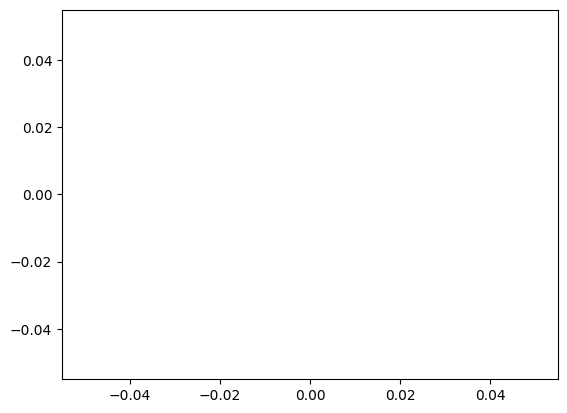

In [26]:
fvc_folder = r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/Masters/Work for others/F12/FVC'
ic_input = r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/Thesis/01-102/01-102_V3/ic/l-01-102_V3_IC220W.txt'
input_path = r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/Thesis/01-102/01-102_V3/breaths/l-01-102_V3_B220W.txt'

mefv = spirometry.mefv_curve(fvc_folder, settings)
def get_vecap(mefv, ic_input, input_path):
    ic = get_ic(ic_input, pdf, settings)
    avginsp_df, avgexp_df, te, ti, fb, vt, ve = gnar.averagebreaths(input_path, pdf, settings)
    erv = (spirometry.get_fvc(mefv) - ic).round(2)
    irv = (erv + vt).round(2)
    avgexp_df.volume = avgexp_df.volume + erv

    start = mefv.index[mefv['volume']==erv][0]
    end = mefv.index[mefv['volume']==irv][0]
    temax = 0
    for i in range(start, end):
        mef = mefv.flow[i]
        temax+= 0.01/mef

    ttot = te+ti
    ttotmax = temax/(te/(te+ti))
    fbmax = 60/ttotmax
    vecap = vt * fbmax


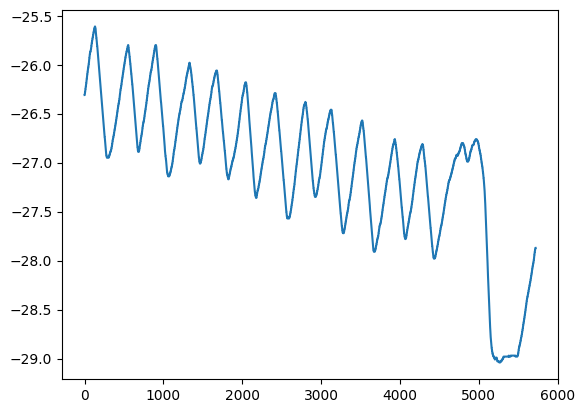

In [23]:
file = r'/Users/jackdunsford/Library/CloudStorage/OneDrive-Personal/Masters/Work for others/F12/IC/LLGrind_F11_V1_E_04.txt'

data = pd.read_csv(file, delimiter='\t', names=['volume'])
# volume = data['volume'] - data['volume'][0]
plt.plot(data['volume'])